In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

plt.style.use('ggplot')
%matplotlib inline

x_train = pd.read_csv('data/x_train_norm.csv', sep=';', na_values='?')
x_test = pd.read_csv('data/x_test_norm.csv', sep=';', na_values='?')
y_train = pd.read_csv('data/y_train.csv', sep=';', header=None, na_values='?')[0]



# import scipy as sp
# def logloss(act, pred):
#     epsilon = 1e-15
#     pred = sp.maximum(epsilon, pred)
#     pred = sp.minimum(1-epsilon, pred)
#     ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
#     ll = ll * -1.0/len(act)
#     return ll

# def scorer_logloss(estimator, X, y):
#     return logloss(y, estimator.predict_proba(X)[:,1])

def scorer_logloss(estimator, X, y):
    return log_loss(y, estimator.predict_proba(X)) # аналогично этому: estimator.predict_proba(X)[:,1]

def revert_scorer_logloss(estimator, X, y):
    return -1 * scorer_logloss(estimator, X, y)

In [2]:
from imblearn.over_sampling import SMOTE 

ImportError: No module named imblearn.over_sampling

In [3]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(x_train, y_train)

In [5]:
len(y_res)

36002

In [5]:
classifier = GradientBoostingClassifier(learning_rate=0.02/3, # 0.00(6)
                                        n_estimators=975,
                                        subsample=0.8,
                                        min_samples_split=950,
                                        min_samples_leaf=50,
                                        max_depth=9,
                                        max_features=3,
                                        random_state=11)
classifier.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.00666666666667, loss='deviance', max_depth=9,
              max_features=3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=950, min_weight_fraction_leaf=0.0,
              n_estimators=975, presort='auto', random_state=11,
              subsample=0.8, verbose=0, warm_start=False)

In [ ]:
classifier = GradientBoostingClassifier(learning_rate=0.02/3, # 0.00(6)
                                        n_estimators=975,
                                        subsample=0.8,
                                        min_samples_split=950,
                                        min_samples_leaf=50,
                                        max_depth=9,
                                        max_features=3,
                                        random_state=11)
classifier.fit(X_res, y_res)

In [7]:
cross_val_score(classifier, X_res, y_res, scoring='neg_log_loss')

array([-0.4582429 , -0.35549983, -0.35340366])

In [21]:
cv = cross_val_score(classifier, X_res, y_res, scoring='neg_log_loss', cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=5))
print np.mean(cv), cv
cv = cross_val_score(classifier, x_train, y_train, scoring='neg_log_loss', cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=5))
print np.mean(cv), cv

-0.370258277033 [-0.36636891 -0.37177761 -0.37262831]
-0.381166034907 [-0.37258293 -0.38214301 -0.38877216]


In [11]:
y_test = classifier.predict_proba(x_test)[:,1]
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/012_smote_1.csv', sep=';', header=None, index=False)

In [12]:
def drow_scatter(x, y, feature1, feature2, split=False):
    data_drow=pd.concat((x[feature1], x[feature2], y), axis=1)
    data_drow.columns=[feature1,feature2,'class']

    plt.figure(figsize=(10, 6))

    if split:
        plt.subplot(1, 2, 1)

    plt.scatter(data_drow[feature1][data_drow['class'] == 1],
                data_drow[feature2][data_drow['class'] == 1],
                alpha=0.75,
                color='red',
                label='1')

    if split:
        plt.subplot(1, 2, 2)
    plt.scatter(data_drow[feature1][data_drow['class'] == 0],
                data_drow[feature2][data_drow['class'] == 0],
                alpha=0.75,
                color='blue',
                label='0')

    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(loc='best');

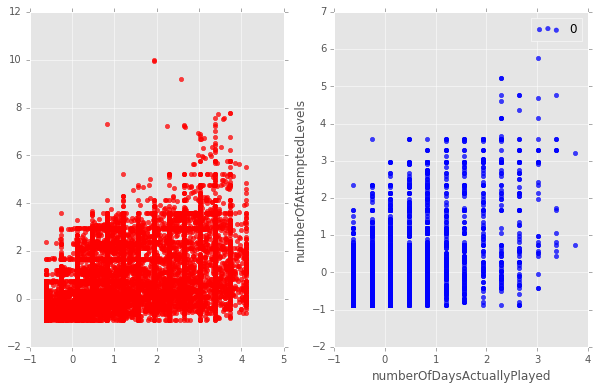

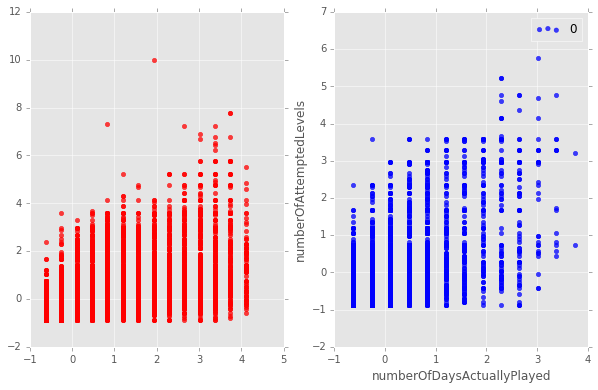

In [22]:
X_res=pd.DataFrame(X_res, columns=x_train.columns)
y_res = pd.Series(y_res)
drow_scatter(X_res, y_res, 'numberOfDaysActuallyPlayed', 'numberOfAttemptedLevels', True)
drow_scatter(x_train, y_train, 'numberOfDaysActuallyPlayed', 'numberOfAttemptedLevels', True)

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(x_train)

In [26]:
X_vis=pd.DataFrame(X_vis, columns=['f1', 'f2'])

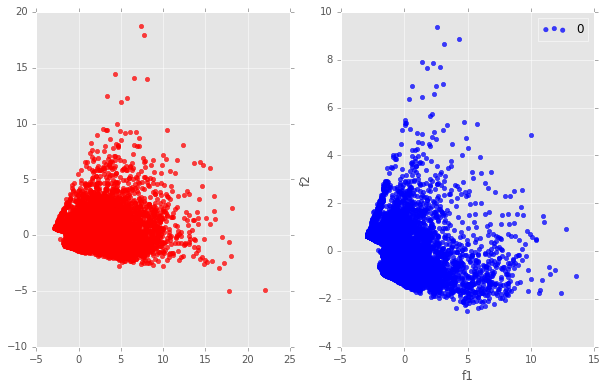

In [29]:
drow_scatter(X_vis, y_train, 'f1', 'f2', True)

In [7]:
xx_train = pd.read_csv('data/x_train.csv', sep=';', na_values='?')
xx_test = pd.read_csv('data/x_test.csv', sep=';', na_values='?')

In [8]:
xx_train['y']=y_train
total = xx_train.groupby(['numberOfDaysActuallyPlayed']).size()
total=pd.DataFrame(total, columns=['total'])

In [101]:
#xx_train[new]
y1=xx_train[['numberOfDaysActuallyPlayed', 'y']].groupby(['numberOfDaysActuallyPlayed']).sum()
y1=pd.Series(y1['y'], name='y1') #, index=y1['numberOfDaysActuallyPlayed'])

In [105]:
total = pd.concat([total, y1], columns=['total', 'y1'], axis=1)

TypeError: concat() got an unexpected keyword argument 'columns'

In [103]:
#total#['0']
total['y0']=total['total']-total['y1']

In [93]:
total

,total,y,y0
numberOfDaysActuallyPlayed,,,
1,13373,921,12452
2,3670,954,2716
3,2211,963,1248
4,1507,892,615
5,1147,794,353
6,662,482,180
7,581,433,148
8,457,365,92
9,432,348,84


In [112]:
xx_train[xx_train['numberOfDaysActuallyPlayed']==1].groupby(['y']).size()

y
0    12452
1      921
dtype: int64

In [114]:
xx_train[(xx_train['numberOfDaysActuallyPlayed']>1)&(xx_train['numberOfDaysActuallyPlayed']<14)].groupby(['y']).size()

y
0    5549
1    6282
dtype: int64

In [115]:
#2..13

In [120]:
idx=xx_train[(xx_train['numberOfDaysActuallyPlayed']>1)&(xx_train['numberOfDaysActuallyPlayed']<14)].index
#x_train[xx_train[(xx_train['numberOfDaysActuallyPlayed']>1)&(xx_train['numberOfDaysActuallyPlayed']<14)].index]

In [9]:
types=pd.Series(np.zeros(x_train.shape[0]), dtype=int)
types[xx_train[(xx_train['numberOfDaysActuallyPlayed']>1)&(xx_train['numberOfDaysActuallyPlayed']<14)].index]=1
types[xx_train[xx_train['numberOfDaysActuallyPlayed']==14].index]=2

test_types=pd.Series(np.zeros(x_test.shape[0]), dtype=int)
test_types[xx_test[(xx_test['numberOfDaysActuallyPlayed']>1)&(xx_test['numberOfDaysActuallyPlayed']<14)].index]=1
test_types[xx_test[xx_test['numberOfDaysActuallyPlayed']==14].index]=2

In [197]:
#1
xxx_train=x_train.loc[types[types==1].index]
yyy_train=y_train.loc[types[types==1].index]

xxx_train=xxx_train.reset_index(drop=True)
yyy_train=yyy_train.reset_index(drop=True)

In [24]:
def fit(X, y, grid_params, clf_params, fit_params={}):
    estimator = GradientBoostingClassifier(**clf_params)
    grid = GridSearchCV(
        estimator=estimator, 
        param_grid = params,
        fit_params=fit_params,
        scoring='neg_log_loss',
        n_jobs=4,
        iid=False,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=5))

    grid.fit(xxx_train, yyy_train)
    print grid.best_params_, -grid.best_score_
    return grid.best_params_

In [214]:
opt_params={}

default_params={
    'n_estimators':47,
    'learning_rate':0.1,
    'min_samples_split':500,
    'min_samples_leaf':50,
    'max_depth':8,
    'max_features':'sqrt',
    'subsample':0.8,
    'random_state':11    
}


# default_params={'learning_rate': 0.01,
#  'max_depth': 8,
#  'max_features': 3,
#  'min_samples_leaf': 50,
#  'min_samples_split': 875,
#  'n_estimators': 590,
#  'random_state': 11,
#  'subsample': 0.80000000000000027}

opt_params=dict(opt_params, **opt_fit_params)
clf_params=dict(default_params, **opt_params)
clf_params

{'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 50,
 'min_samples_split': 500,
 'n_estimators': 100,
 'random_state': 11,
 'subsample': 0.8}

In [216]:
params = {'n_estimators':np.concatenate((range(10,101,10), range(41,50), range(51,60)))}
opt_fit_params = fit(xxx_train, yyy_train, params, clf_params)

opt_params=dict(opt_params, **opt_fit_params)
clf_params=dict(default_params, **opt_params)
clf_params

{'n_estimators': 47} 0.559387892073


{'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 50,
 'min_samples_split': 500,
 'n_estimators': 47,
 'random_state': 11,
 'subsample': 0.8}

In [218]:
params = {'max_depth':range(5,16,2),
          'min_samples_split':range(200,1001,200)}

opt_fit_params = fit(xxx_train, yyy_train, params, clf_params)

opt_params=dict(opt_params, **opt_fit_params)
clf_params=dict(default_params, **opt_params)
clf_params

{'min_samples_split': 800, 'max_depth': 7} 0.558448811771


{'learning_rate': 0.1,
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 50,
 'min_samples_split': 800,
 'n_estimators': 47,
 'random_state': 11,
 'subsample': 0.8}

In [219]:
max_depth_opt = 7
min_samples_split_opt = 800

params = {'max_depth': range(max_depth_opt-2,max_depth_opt+3),
          'min_samples_split':range(min_samples_split_opt-200, min_samples_split_opt+201,25)}

opt_fit_params = fit(xxx_train, yyy_train, params, clf_params)

opt_params=dict(opt_params, **opt_fit_params)
clf_params=dict(default_params, **opt_params)
clf_params

{'min_samples_split': 875, 'max_depth': 8} 0.557980032562


{'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 50,
 'min_samples_split': 875,
 'n_estimators': 47,
 'random_state': 11,
 'subsample': 0.8}

In [220]:
params={'min_samples_leaf':range(20,81,10)}
opt_fit_params = fit(xxx_train, yyy_train, params, clf_params)

opt_params=dict(opt_params, **opt_fit_params)
clf_params=dict(default_params, **opt_params)
clf_params

{'min_samples_leaf': 50} 0.557980032562


{'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 50,
 'min_samples_split': 875,
 'n_estimators': 47,
 'random_state': 11,
 'subsample': 0.8}

In [221]:
params = {'max_features':range(2,13)}
opt_fit_params = fit(xxx_train, yyy_train, params, clf_params)

opt_params=dict(opt_params, **opt_fit_params)
clf_params=dict(default_params, **opt_params)
clf_params

{'max_features': 3} 0.557980032562


{'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 3,
 'min_samples_leaf': 50,
 'min_samples_split': 875,
 'n_estimators': 47,
 'random_state': 11,
 'subsample': 0.8}

In [222]:
params = {'n_estimators':range(55, 61)}
opt_fit_params = fit(xxx_train, yyy_train, params, clf_params)

opt_params=dict(opt_params, **opt_fit_params)
clf_params=dict(default_params, **opt_params)
clf_params

{'n_estimators': 59} 0.557870342673


{'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 3,
 'min_samples_leaf': 50,
 'min_samples_split': 875,
 'n_estimators': 59,
 'random_state': 11,
 'subsample': 0.8}

In [223]:
params = {'subsample': np.arange(0.5,0.9,0.1/5.0)}
opt_fit_params = fit(xxx_train, yyy_train, params, clf_params)

opt_params=dict(opt_params, **opt_fit_params)
clf_params=dict(default_params, **opt_params)
clf_params

{'subsample': 0.80000000000000027} 0.557870342673


{'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 3,
 'min_samples_leaf': 50,
 'min_samples_split': 875,
 'n_estimators': 59,
 'random_state': 11,
 'subsample': 0.80000000000000027}

In [224]:
learning_rate=0.1
n_estimators=59
fractions=np.array([0.5,1,5,10,15,20,25,30])

params=[{'learning_rate': [learning_rate/frac], 'n_estimators': [int(n_estimators*frac)]} for frac in fractions]
opt_fit_params = fit(xxx_train, yyy_train, params, clf_params)

opt_params=dict(opt_params, **opt_fit_params)
clf_params=dict(default_params, **opt_params)
clf_params

{'n_estimators': 590, 'learning_rate': 0.01} 0.557814974389


{'learning_rate': 0.01,
 'max_depth': 8,
 'max_features': 3,
 'min_samples_leaf': 50,
 'min_samples_split': 875,
 'n_estimators': 590,
 'random_state': 11,
 'subsample': 0.80000000000000027}

In [ ]:
clf_params={'learning_rate': 0.01,
 'max_depth': 8,
 'max_features': 3,
 'min_samples_leaf': 50,
 'min_samples_split': 875,
 'n_estimators': 590,
 'random_state': 11,
 'subsample': 0.80000000000000027}

In [189]:
cv = cross_val_score(classifier, xxx_train, yyy_train, scoring='neg_log_loss', cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=5))
print np.mean(cv), cv

cv = cross_val_score(GradientBoostingClassifier(**clf_params),
    xxx_train, yyy_train, scoring='neg_log_loss', cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=5))
print np.mean(cv), cv

-0.558153938603 [-0.56132644 -0.55817818 -0.5549572 ]


In [234]:
max_depth_opt = 7
min_samples_split_opt = 800

learning_rate=0.1
n_estimators=59
fractions=np.array([0.5,1,5,10,15,20,25,30])

super_params = [
    {'n_estimators':np.concatenate((range(10,101,10), range(41,50), range(51,60)))},
    {
        'max_depth':range(5,16,2),
        'min_samples_split':range(200,1001,200)
    },     
    {
        'max_depth': range(max_depth_opt-2,max_depth_opt+3),
        'min_samples_split':range(min_samples_split_opt-200, min_samples_split_opt+201,25)
    },
    {'min_samples_leaf':range(20,81,10)},
    {'max_features':range(2,13)},
    {'n_estimators':range(n_estimators-10, n_estimators+10)},
    {'subsample': np.arange(0.5,0.9,0.1/5.0)},
    [{'learning_rate': [learning_rate/frac], 'n_estimators': [int(n_estimators*frac)]} for frac in fractions]
]

In [235]:
opt_params={}

default_params={
    'n_estimators':47,
    'learning_rate':0.1,
    'min_samples_split':500,
    'min_samples_leaf':50,
    'max_depth':8,
    'max_features':'sqrt',
    'subsample':0.8,
    'random_state':11    
}

opt_params=dict(opt_params, **opt_fit_params)
clf_params=dict(default_params, **opt_params)
clf_params

{'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 50,
 'min_samples_split': 500,
 'n_estimators': 100,
 'random_state': 11,
 'subsample': 0.8}

In [236]:
for params in super_params:
    opt_fit_params = fit(xxx_train, yyy_train, params, clf_params)

    opt_params=dict(opt_params, **opt_fit_params)
    clf_params=dict(default_params, **opt_params)
    print clf_params

{'n_estimators': 47} 0.559387892073
{'learning_rate': 0.1, 'min_samples_leaf': 50, 'n_estimators': 47, 'subsample': 0.8, 'random_state': 11, 'max_features': 'sqrt', 'min_samples_split': 500, 'max_depth': 8}
{'min_samples_split': 800, 'max_depth': 7} 0.558448811771
{'learning_rate': 0.1, 'min_samples_leaf': 50, 'n_estimators': 47, 'subsample': 0.8, 'random_state': 11, 'max_features': 'sqrt', 'min_samples_split': 800, 'max_depth': 7}
{'min_samples_split': 875, 'max_depth': 8} 0.557980032562
{'learning_rate': 0.1, 'min_samples_leaf': 50, 'n_estimators': 47, 'subsample': 0.8, 'random_state': 11, 'max_features': 'sqrt', 'min_samples_split': 875, 'max_depth': 8}
{'min_samples_leaf': 50} 0.557980032562
{'learning_rate': 0.1, 'min_samples_leaf': 50, 'n_estimators': 47, 'subsample': 0.8, 'random_state': 11, 'max_features': 'sqrt', 'min_samples_split': 875, 'max_depth': 8}
{'max_features': 3} 0.557980032562
{'learning_rate': 0.1, 'min_samples_leaf': 50, 'n_estimators': 47, 'subsample': 0.8, 'ran

In [237]:
clf_params

{'learning_rate': 0.01,
 'max_depth': 8,
 'max_features': 3,
 'min_samples_leaf': 50,
 'min_samples_split': 875,
 'n_estimators': 590,
 'random_state': 11,
 'subsample': 0.80000000000000027}

In [357]:
#0
xxx_train=x_train.loc[types[types==0].index]
yyy_train=y_train.loc[types[types==0].index]

xxx_train=xxx_train.reset_index(drop=True)
yyy_train=yyy_train.reset_index(drop=True)

In [358]:
learning_rate=0.1
n_estimators=19
fractions=np.array([0.5,1,5,10,15,20,25,30])

super_params = [
    {'n_estimators': [19]},#np.concatenate((range(10,101,10), range(10,20), range(21,30)))},
    {
        'max_depth':range(3,10),
        'min_samples_split':range(400,701,25) #range(200,1001,200)
    },     
    {'min_samples_leaf':range(20,81,10)},
    {'max_features':range(2,13)},
    {'subsample': np.arange(0.5,0.9,0.1/5.0)},
    [{'learning_rate': [learning_rate/frac], 'n_estimators': [int(n_estimators*frac)]} for frac in fractions]
]

In [359]:
opt_params={}

default_params={
    'n_estimators':47,
    'learning_rate':0.1,
    'min_samples_split':500,
    'min_samples_leaf':50,
    'max_depth':8,
    'max_features':'sqrt',
    'subsample':0.8,
    'random_state':11    
}

#opt_params=dict(opt_params, **opt_fit_params)
clf_params=dict(default_params, **opt_params)
clf_params

{'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 50,
 'min_samples_split': 500,
 'n_estimators': 47,
 'random_state': 11,
 'subsample': 0.8}

In [360]:
for params in super_params:
    opt_fit_params = fit(xxx_train, yyy_train, params, clf_params)

    opt_params=dict(opt_params, **opt_fit_params)
    clf_params=dict(default_params, **opt_params)
    print clf_params

{'n_estimators': 19} 0.22967931245
{'learning_rate': 0.1, 'min_samples_leaf': 50, 'n_estimators': 19, 'subsample': 0.8, 'random_state': 11, 'max_features': 'sqrt', 'min_samples_split': 500, 'max_depth': 8}
{'min_samples_split': 600, 'max_depth': 5} 0.228505998048
{'learning_rate': 0.1, 'min_samples_leaf': 50, 'n_estimators': 19, 'subsample': 0.8, 'random_state': 11, 'max_features': 'sqrt', 'min_samples_split': 600, 'max_depth': 5}
{'min_samples_leaf': 50} 0.228505998048
{'learning_rate': 0.1, 'min_samples_leaf': 50, 'n_estimators': 19, 'subsample': 0.8, 'random_state': 11, 'max_features': 'sqrt', 'min_samples_split': 600, 'max_depth': 5}
{'max_features': 3} 0.228505998048
{'learning_rate': 0.1, 'min_samples_leaf': 50, 'n_estimators': 19, 'subsample': 0.8, 'random_state': 11, 'max_features': 3, 'min_samples_split': 600, 'max_depth': 5}
{'subsample': 0.66000000000000014} 0.228498109259
{'learning_rate': 0.1, 'min_samples_leaf': 50, 'n_estimators': 19, 'subsample': 0.66000000000000014, 'r

In [361]:
clf_params

{'learning_rate': 0.10000000000000001,
 'max_depth': 5,
 'max_features': 3,
 'min_samples_leaf': 50,
 'min_samples_split': 600,
 'n_estimators': 19,
 'random_state': 11,
 'subsample': 0.66000000000000014}

In [265]:
cv = cross_val_score(classifier,
                     xxx_train,
                     yyy_train,
                     scoring='neg_log_loss',
                     cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=5))
print -1 * np.mean(cv), -1*cv

cv = cross_val_score(GradientBoostingClassifier(**clf_params),
                     xxx_train,
                     yyy_train,
                     scoring='neg_log_loss',
                     cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=5))
print -1 * np.mean(cv), -1*cv

0.230338214504 [ 0.22951003  0.23536701  0.23593548  0.22713865  0.2237399 ]
0.228785338204 [ 0.22872268  0.23415678  0.2327544   0.22616093  0.22213189]


In [362]:
class FakeClf:
    def predict_proba(self, X):
        ret=np.ndarray(shape=(X.shape[0],2), dtype=float)
        ret[:,0]=0
        ret[:,1]=1
        return ret

params0={'learning_rate': 0.10000000000000001,
         'max_depth': 5,
         'max_features': 3,
         'min_samples_leaf': 50,
         'min_samples_split': 600,
         'n_estimators': 19,
         'random_state': 11,
         'subsample': 0.66000000000000014}
classifier0 = GradientBoostingClassifier(**params0)
xxx_train, yyy_train = x_train.loc[types[types==0].index], y_train.loc[types[types==0].index]
classifier0.fit(xxx_train, yyy_train)

params1={'learning_rate': 0.01,
         'max_depth': 8,
         'max_features': 3,
         'min_samples_leaf': 50,
         'min_samples_split': 875,
         'n_estimators': 590,
         'random_state': 11,
         'subsample': 0.80000000000000027}
classifier1 = GradientBoostingClassifier(**params1)
xxx_train, yyy_train = x_train.loc[types[types==1].index], y_train.loc[types[types==1].index]
classifier1.fit(xxx_train, yyy_train)

clf={
    0: classifier0,
    1: classifier1,
    2: FakeClf()
}

In [326]:
clf[2].predict_proba(x_test)[:,1]

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [364]:
res=pd.DataFrame(index=x_test.index)
for i in clf.keys():
    res['clf'+str(i)]=clf[i].predict_proba(x_test)[:,1]


In [365]:
res['types']=test_types

In [366]:
res['y']=res.apply(lambda row: row['clf'+str(int(row['types']))], axis=1)


In [368]:
res_df = res['y']# pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/012_3_clf.csv', sep=';', header=None, index=False)

In [369]:
res['good_y']=classifier.predict_proba(x_test)[:,1]

In [370]:
res

,clf0,clf1,clf2,types,y,good_y
0,0.120132,0.217156,1.0,0,0.120132,0.165391
1,0.032317,0.106615,1.0,0,0.032317,0.067093
2,0.319942,0.606147,1.0,1,0.606147,0.727772
3,0.287086,0.599790,1.0,1,0.599790,0.724658
4,0.053872,0.139411,1.0,0,0.053872,0.114130
5,0.154390,0.228809,1.0,1,0.228809,0.243620
6,0.155758,0.350422,1.0,1,0.350422,0.456619
7,0.311936,0.695257,1.0,1,0.695257,0.801573
8,0.082639,0.149089,1.0,0,0.082639,0.107632
9,0.029736,0.096416,1.0,0,0.029736,0.051669


0        1
1        1
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
13343    0
13344    0
13345    0
13346    0
13347    0
13348    0
13349    0
13350    0
13351    0
13352    0
13353    0
13354    0
13355    0
13356    1
13357    0
13358    0
13359    0
13360    0
13361    0
13362    1
13363    0
13364    0
13365    0
13366    0
13367    0
13368    0
13369    0
13370    1
13371    0
13372    0
Name: 0, dtype: int64

In [10]:
#0
xxx_train=x_train.loc[types[types==0].index]
yyy_train=y_train.loc[types[types==0].index]

xxx_train=xxx_train.reset_index(drop=True)
yyy_train=yyy_train.reset_index(drop=True)

In [38]:
w=(yyy_train*9)+1
fit_params={'sample_weight': np.array(w)}
fit_params

{'sample_weight': array([10, 10,  1, ..., 10,  1,  1])}

In [45]:
learning_rate=0.1
n_estimators=25
fractions=np.array([0.5,1,5,10,15,20,25,30])

super_params = [
    {'n_estimators': range(100,200,10)},# np.concatenate((range(10,101,10), range(10,20), range(21,30)))},
    {
        'max_depth':range(3,10),
        'min_samples_split':range(400,701,25) #range(200,1001,200)
    },     
    {'min_samples_leaf':range(20,81,10)},
    {'max_features':range(2,13)},
    {'subsample': np.arange(0.5,0.9,0.1/5.0)},
    [{'learning_rate': [learning_rate/frac], 'n_estimators': [int(n_estimators*frac)]} for frac in fractions]
]

In [46]:
opt_params={}

default_params={
    'n_estimators':47,
    'learning_rate':0.1,
    'min_samples_split':500,
    'min_samples_leaf':50,
    'max_depth':8,
    'max_features':'sqrt',
    'subsample':0.8,
    'random_state':11    
}

#opt_params=dict(opt_params, **opt_fit_params)
clf_params=dict(default_params, **opt_params)
clf_params

{'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 50,
 'min_samples_split': 500,
 'n_estimators': 47,
 'random_state': 11,
 'subsample': 0.8}

In [47]:
for params in super_params:
    opt_fit_params = fit(xxx_train, yyy_train, params, clf_params, fit_params)

    opt_params=dict(opt_params, **opt_fit_params)
    clf_params=dict(default_params, **opt_params)
    print clf_params

{'n_estimators': 190} 0.445257570985
{'learning_rate': 0.1, 'min_samples_leaf': 50, 'n_estimators': 190, 'subsample': 0.8, 'random_state': 11, 'max_features': 'sqrt', 'min_samples_split': 500, 'max_depth': 8}
{'min_samples_split': 400, 'max_depth': 9} 0.436266359742
{'learning_rate': 0.1, 'min_samples_leaf': 50, 'n_estimators': 190, 'subsample': 0.8, 'random_state': 11, 'max_features': 'sqrt', 'min_samples_split': 400, 'max_depth': 9}
{'min_samples_leaf': 20} 0.427218139009
{'learning_rate': 0.1, 'min_samples_leaf': 20, 'n_estimators': 190, 'subsample': 0.8, 'random_state': 11, 'max_features': 'sqrt', 'min_samples_split': 400, 'max_depth': 9}
{'max_features': 12} 0.411579994129
{'learning_rate': 0.1, 'min_samples_leaf': 20, 'n_estimators': 190, 'subsample': 0.8, 'random_state': 11, 'max_features': 12, 'min_samples_split': 400, 'max_depth': 9}
{'subsample': 0.8400000000000003} 0.411013223649
{'learning_rate': 0.1, 'min_samples_leaf': 20, 'n_estimators': 190, 'subsample': 0.8400000000000

KeyboardInterrupt: 

In [50]:
log_loss([1],[0.5])

ValueError: y_true contains only one label (1). Please provide the true labels explicitly through the labels argument.

In [51]:
import scipy as sp
def logloss(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll

In [53]:
logloss([1,1],[0.5,0.5])

0.69314718055994529

In [54]:
logloss([1,1,1,1,1],[0.5,0.5,0.5,0.5,0.5])

0.69314718055994529